## Part 1: Analyzing wildfire activities in Australia

### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

### Dataset


**Historical Wildfires**

This wildfire dataset contains data on fire activities in Australia starting from 2005. Additional information can be found [here](https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/c6-mcd14dl).

Variables

- Region: the 7 regions
- Date: in UTC and provide the data for 24 hours ahead
- Estimated_fire_area: daily sum of estimated fire area for presumed vegetation fires with a confidence > 75% for a each region in km2
- Mean_estimated_fire_brightness: daily mean (by flagged fire pixels(=count)) of estimated fire brightness for presumed vegetation fires with a confidence level > 75% in Kelvin
- Mean_estimated_fire_radiative_power: daily mean of estimated radiative power for presumed vegetation fires with a confidence level > 75% for a given region in megawatts
- Mean_confidence: daily mean of confidence for presumed vegetation fires with a confidence level > 75%
- Std_confidence: standard deviation of estimated fire radiative power in megawatts
- Var_confidence: Variance of estimated fire radiative power in megawatts
- Count: daily numbers of pixels for presumed vegetation fires with a confidence level of larger than 75% for a given region
- Replaced: Indicates with an Y whether the data has been replaced with standard quality data when they are available (usually with a 2-3 month lag). Replaced data has a slightly higher quality in terms of locations


#### Importing Data

In [2]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/Historical_Wildfires.csv"
df = pd.read_csv(URL)

In [3]:
df.dtypes

Region                                  object
Date                                    object
Estimated_fire_area                    float64
Mean_estimated_fire_brightness         float64
Mean_estimated_fire_radiative_power    float64
Mean_confidence                        float64
Std_confidence                         float64
Var_confidence                         float64
Count                                    int64
Replaced                                object
dtype: object

Notice the type of 'Date' is object, let's convert it to 'datatime' type and also let's extract 'Year' and 'Month' from date and include in the dataframe as separate columns

In [4]:
import datetime as dt

df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month

In [5]:
df.dtypes

Region                                  object
Date                                    object
Estimated_fire_area                    float64
Mean_estimated_fire_brightness         float64
Mean_estimated_fire_radiative_power    float64
Mean_confidence                        float64
Std_confidence                         float64
Var_confidence                         float64
Count                                    int64
Replaced                                object
Year                                     int32
Month                                    int32
dtype: object

In [6]:
df.Year

0        2005
1        2005
2        2005
3        2005
4        2005
         ... 
26401    2020
26402    2020
26403    2020
26404    2020
26405    2020
Name: Year, Length: 26406, dtype: int32

### TASK 1.1: Let's try to understand the change in average estimated fire area over time (use pandas to plot)

<Figure size 2000x1200 with 0 Axes>

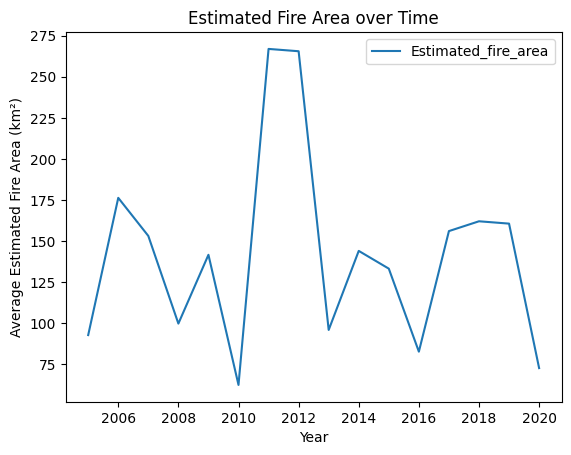

In [7]:
fire_area = df.groupby("Year")["Estimated_fire_area"].mean().reset_index()

plt.figure(figsize=(20, 12))
fire_area.plot(x="Year", y="Estimated_fire_area", kind="line")
plt.xlabel('Year')
plt.ylabel('Average Estimated Fire Area (km²)')
plt.title('Estimated Fire Area over Time')
plt.show()

### TASK 1.2: You can notice the peak in the plot between 2010 to 2013. Let's narrow down our finding, by plotting the estimated fire area for year grouped together with month.

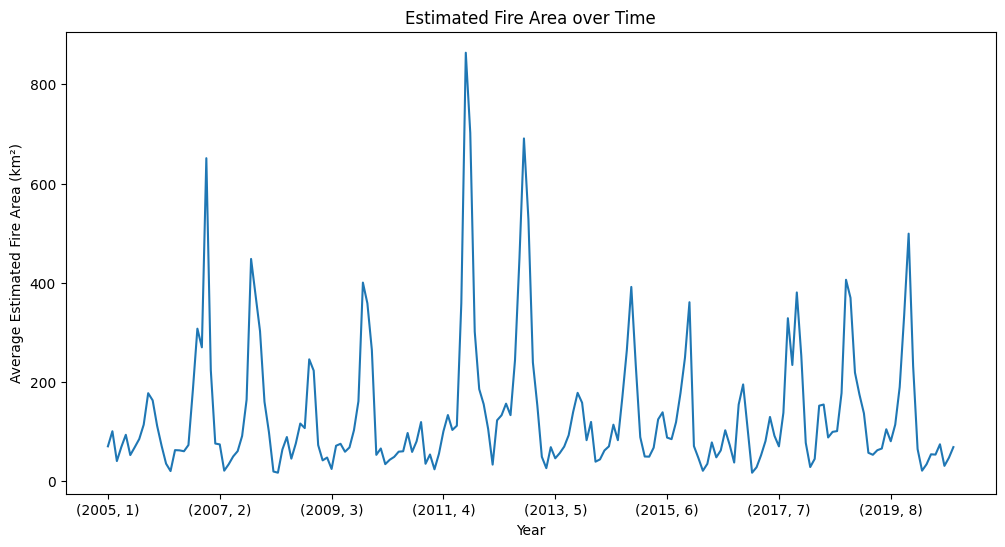

In [8]:
fire_area = df.groupby(["Year", "Month"])["Estimated_fire_area"].mean()

plt.figure(figsize=(12, 6))
fire_area.plot(x=fire_area.index, y=fire_area.values)
plt.xlabel('Year')
plt.ylabel('Average Estimated Fire Area (km²)')
plt.title('Estimated Fire Area over Time')
plt.show()

### TASK 1.3: Let's have an insight on the distribution of mean estimated fire brightness across the regions, use the functionality of seaborn to develop a barplot

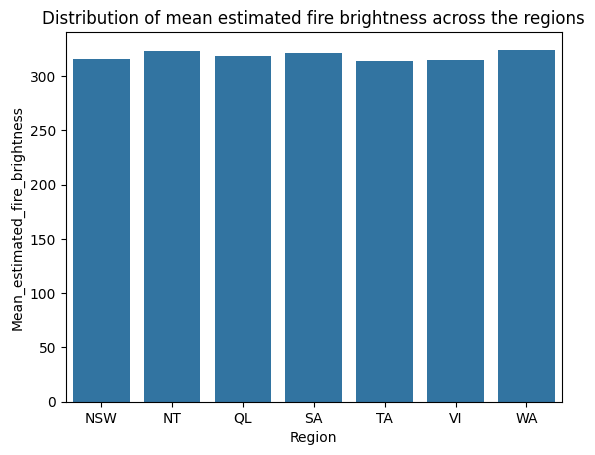

In [9]:
df2 = df.groupby("Region")["Mean_estimated_fire_brightness"].mean().reset_index()
sns.barplot(x="Region", y="Mean_estimated_fire_brightness", data=df2)
plt.title("Distribution of mean estimated fire brightness across the regions")
plt.xlabel("Region")
plt.ylabel("Mean_estimated_fire_brightness")
plt.show()

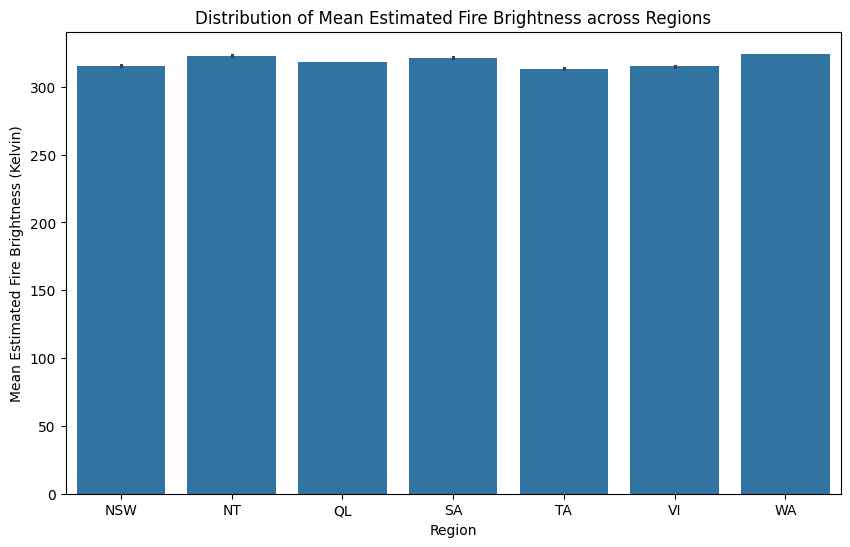

In [10]:
# Creating a bar plot using seaborn to visualize the distribution of mean estimated fire brightness across regions
plt.figure(figsize=(10, 6))
# Using seaborn's barplot function to create the plot
sns.barplot(data=df, x='Region', y='Mean_estimated_fire_brightness')
plt.xlabel('Region')
plt.ylabel('Mean Estimated Fire Brightness (Kelvin)')
plt.title('Distribution of Mean Estimated Fire Brightness across Regions')
plt.show()

### TASK 1.4: Let's find the portion of count of pixels for presumed vegetation fires vary across regions, we will develop a pie chart for this

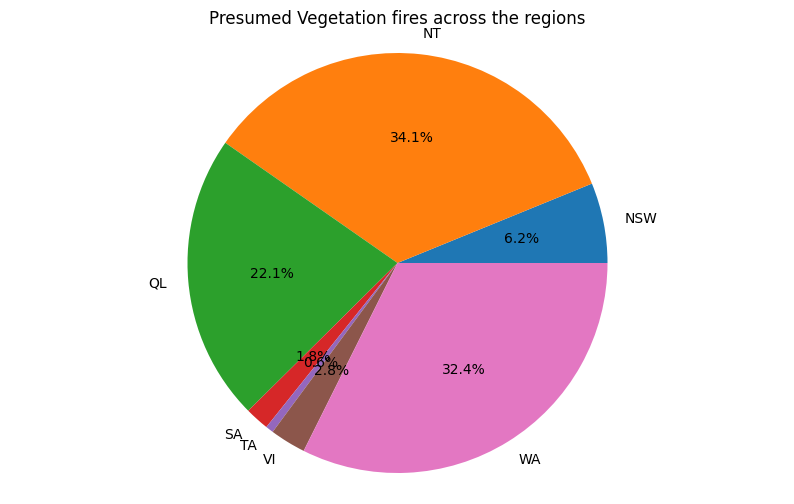

In [11]:
df3 = df.groupby("Region")["Count"].sum()

plt.figure(figsize=(10, 6))
plt.pie(df3, labels=df3.index, autopct="%1.1f%%")
plt.title("Presumed Vegetation fires across the regions")
plt.axis('equal')
plt.show()

### TASK 1.5: See the percentage on the pie is not looking so good as it is overlaped for Region SA, TA, VI

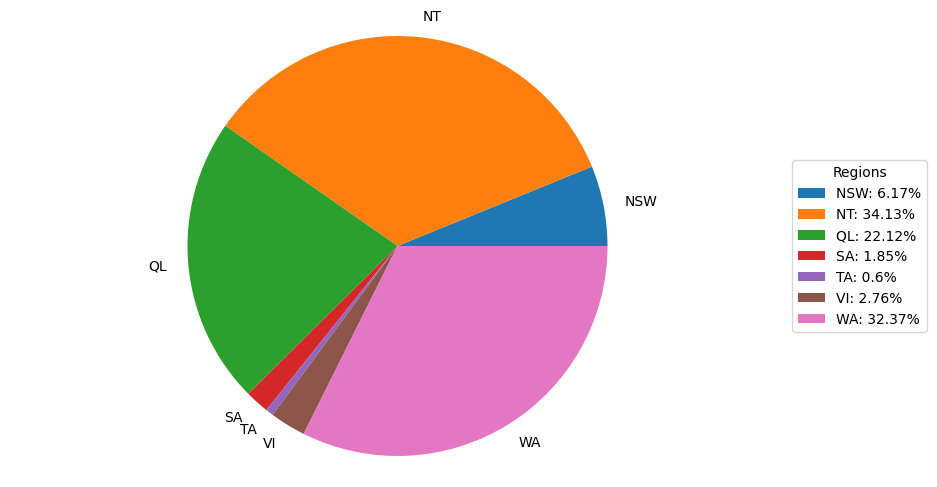

In [12]:
legend_labels = [(i, round(k/df3.sum()*100, 2)) for i, k in zip(df3.index, df3)]
legend_labels = [f'{label[0]}: {label[1]}%' for label in legend_labels]

plt.figure(figsize=(10, 6))
plt.pie(df3, labels=df3.index)
plt.legend(legend_labels, title="Regions", loc="center left", bbox_to_anchor=(1, 0.5))
plt.axis('equal')
plt.show()

### TASK 1.6: Let's try to develop a histogram of the mean estimated fire brightness. Using Matplotlib to create the histogram

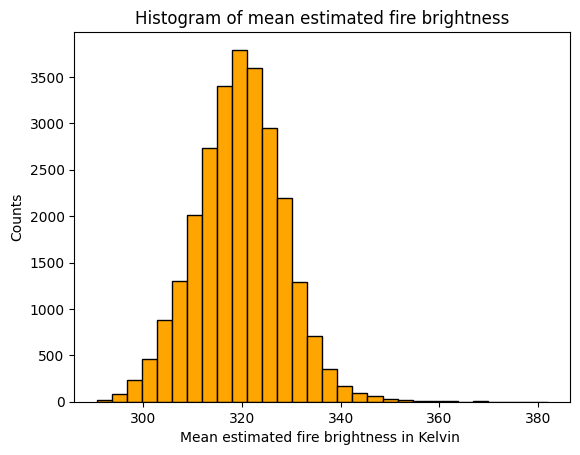

In [13]:
plt.hist(df["Mean_estimated_fire_brightness"], bins=30, color="orange", edgecolor="black")
plt.title("Histogram of mean estimated fire brightness")
plt.xlabel("Mean estimated fire brightness in Kelvin ")
plt.ylabel("Counts")
plt.show()

### TASK 1.7: What if we need to understand the distribution of estimated fire brightness across regions? Let's use the functionality of seaborn and pass region as hue

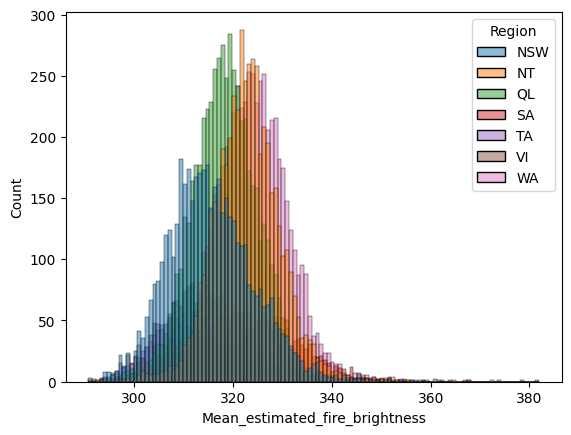

In [14]:
sns.histplot(data=df, x='Mean_estimated_fire_brightness', hue='Region')
plt.show()

looks better!, now include the parameter multiple='stack' in the histplot() and see the difference. Include labels and titles as well

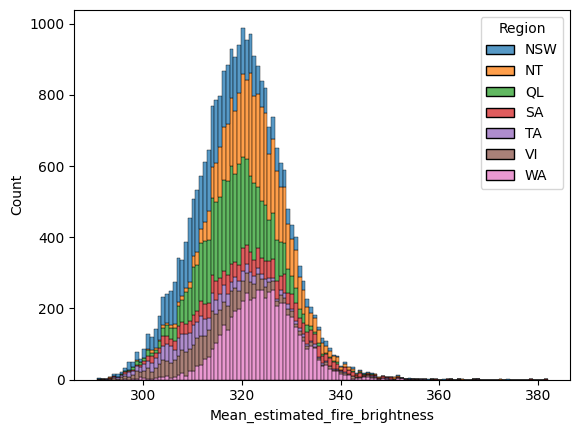

In [15]:
sns.histplot(data=df, x='Mean_estimated_fire_brightness', hue='Region', multiple='stack')
plt.show()

### TASK 1.8: Let's try to find if there is any correlation between mean estimated fire radiative power and mean confidence level

In [16]:
df4 = df[["Mean_estimated_fire_radiative_power", "Mean_confidence"]]
df4.corr()

,Mean_estimated_fire_radiative_power,Mean_confidence
Mean_estimated_fire_radiative_power,1.000000,0.452322
Mean_confidence,0.452322,1.000000


<Axes: xlabel='Mean_confidence', ylabel='Mean_estimated_fire_radiative_power'>

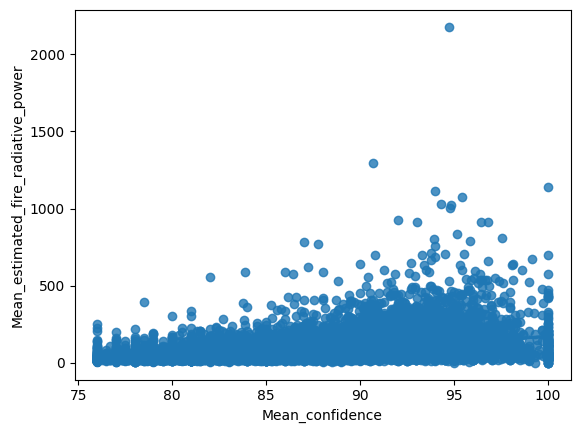

In [17]:
sns.regplot(data=df4, y="Mean_estimated_fire_radiative_power", x="Mean_confidence")

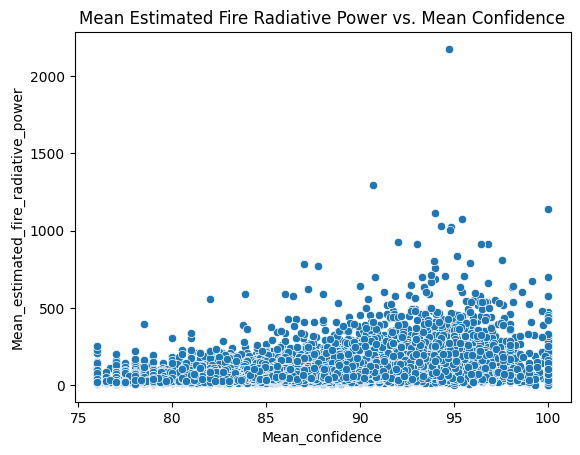

In [18]:
sns.scatterplot(data=df, x='Mean_confidence', y='Mean_estimated_fire_radiative_power')
plt.title('Mean Estimated Fire Radiative Power vs. Mean Confidence')
plt.show()

### TASK 1.9: Let's mark these seven regions on the Map of Australia using Folium

we have created a dataframe for you containing the regions, their latitudes and longitudes.
For australia use [-25, 135] as location to create the map

In [19]:
region_data = {'region':['NSW','QL','SA','TA','VI','WA','NT'], 'Lat':[-31.8759835,-22.1646782,-30.5343665,-42.035067,-36.5986096,-25.2303005,-19.491411], 
               'Lon':[147.2869493,144.5844903,135.6301212,146.6366887,144.6780052,121.0187246,132.550964]}
reg=pd.DataFrame(region_data)
reg

,region,Lat,Lon
0,NSW,-31.875984,147.286949
1,QL,-22.164678,144.584490
2,SA,-30.534367,135.630121
3,TA,-42.035067,146.636689
4,VI,-36.598610,144.678005
5,WA,-25.230300,121.018725
6,NT,-19.491411,132.550964


In [20]:
# instantiate a feature group 
aus_reg = folium.map.FeatureGroup()

# Create a Folium map centered on Australia
Aus_map = folium.Map(location=[-25, 135], zoom_start=4)

# loop through the region and add to feature group
for lat, lng, lab in zip(reg.Lat, reg.Lon, reg.region):
    aus_reg.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            popup=lab,
            radius=10, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
Aus_map.add_child(aus_reg)